# Preparing a GHZ state and running the circuit on simulators

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

This hello-world tutorial prepares a paradigmatic example for a multi-qubit entangled state, the so-called [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) (named after the three physicists Greenberger, Horne and Zeilinger). The GHZ state is extremely non-classical, and therefore very sensitive to decoherence. Therefore, it is often used as a performance benchmark for today's hardware. Moreover, in many quantum information protocols it is used as a resource for quantum error correction, quantum communication and quantum metrology. 

Amazon Braket offers several classical simulators including a local simulator and three on-demand simulators: a full state-vector simulator SV1, a density matrix simulator DM1, and a tensor-network simulator TN1. You can seamlessly swap between different devices without any modifications to the circuit definition, as shown below, by just re-defining the device object. For additional information about simulators, see the [Amazon Braket Dev Guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#choose-a-simulator).

In [2]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import Devices, LocalSimulator
from braket.aws import AwsDevice

### Problem: Prepare a GHZ State

Goal: Prepare an $N$-qubit GHZ state: 
$$\left|0,0, ...\right> \rightarrow \left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0, ...\right> + \left|1,1, ...\right>\right).$$

The GHZ state is a quantum superposition of all subsystems being in state 0 with all of them being in state 1 (as often discussed in the famous Gedanken experiment of a cat being dead and alive at the same time). The GHZ state is a maximally entangled quantum state. 

To prepare this state, build and run the following circuit using a single-qubit Hadamard gate (denoted as H) acting on the first qubit followed by a series of two-qubit CNOT gates: 

<div align="center">
<img src="circuit.png" width="300"/>
</div>

### Setup Circuit

In [3]:
# function to build a GHZ state
def ghz_circuit(n_qubits):
    """
    function to return a GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit

In [4]:
# define circuit
n_qubits = 10
ghz = ghz_circuit(n_qubits)

In [5]:
# print circuit
print(ghz)

T  : |0|1|2|3|4|5|6|7|8|9|
                          
q0 : -H-C-----------------
        |                 
q1 : ---X-C---------------
          |               
q2 : -----X-C-------------
            |             
q3 : -------X-C-----------
              |           
q4 : ---------X-C---------
                |         
q5 : -----------X-C-------
                  |       
q6 : -------------X-C-----
                    |     
q7 : ---------------X-C---
                      |   
q8 : -----------------X-C-
                        | 
q9 : -------------------X-

T  : |0|1|2|3|4|5|6|7|8|9|


### Local Simulator

First, the circuit is run locally using the local simulator.

In [6]:
# set up device: Local Simulator
device = LocalSimulator(backend="qrack")

In [7]:
# run circuit
result = device.run(ghz, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
Counter({'0000000000': 528, '1111111111': 472})


Text(0, 0.5, 'counts')

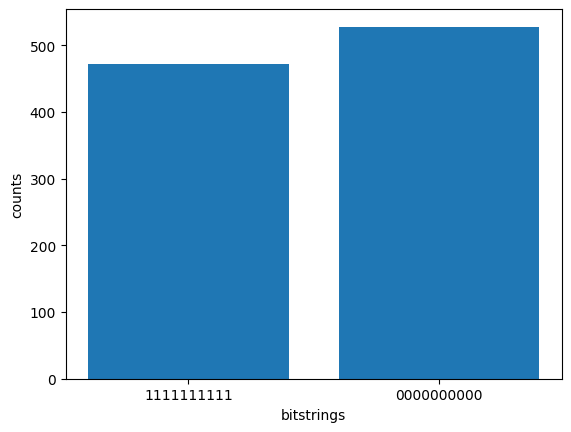

In [8]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

As opposed to quantum hardware where only measurement shots can be obtained, with a classical simulator you can access the full state vector, amplitudes and expectation values of certain observables by assigning the corresponding result types. To do so, append the result types to the circuit before submitting it to run. This can be very useful for debugging. 

The example code below outputs the state vector, the expectation value of $Z\otimes Z\otimes Z$, and the amplitude of the $|111\rangle$ state of a three-qubit GHZ state. 

To reiterate, the following output is expected:
$$\left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0,0\right> + \left|1,1,1\right>\right) = \left[\frac{1}{\sqrt{2}},0,0,0,0,0,0,\frac{1}{\sqrt{2}}\right],$$

for which $\left<ZZZ\right>=0$ and $\left<111|\mathrm{GHZ}\right>=\frac{1}{\sqrt{2}}$.

In [9]:
# define circuit
n_qubits = 3
ghz = ghz_circuit(n_qubits)      

# add the state_vector ResultType
ghz.state_vector()
# print circuit including requested result types
print(ghz)

T  : |0|1|2|
            
q0 : -H-C---
        |   
q1 : ---X-C-
          | 
q2 : -----X-

T  : |0|1|2|

Additional result types: StateVector


In [10]:
# run the circuit and output the results
task = device.run(ghz, shots=0)
result = task.result()

# print results
print("Final EXACT state vector:\n", result.values[0])

Final EXACT state vector:
 [(0.024382350966334343-0.70668625831604j), 0j, 0j, 0j, 0j, 0j, 0j, (0.024382350966334343-0.70668625831604j)]


Clearly the expected results with perfect correlations between the three qubits making up the GHZ state are obtained.

Note that you can only request state vector and amplitude when shots = 0 for a classical simulator. When shots = 0 for a simulator, you get the exact values of probability, expectation values, and variance, as derived from the full wave function. When shots > 0, you cannot access the full state vector, but you can get approximate expectation values as taken from measurement samples. Note that Amazon Braket also supports probability, sample, expectation, and variance as result types for QPU devices.

### The On-Demand Simulators

Apart from the local simulator, you can also run your circuit on an on-demand simulator. This approach adds some latency overhead, but is beneficial for larger circuits by leveraging the optimized cloud hardware infrastructure. Moreover, all your results will be stored reliably in S3.

Amazon Braket provides three on-demand simulators:
* SV1

    State vector simulator  supports simulations of circuits with up to 34 qubits, calculates and keeps track of the full state vector evolution.
* TN1

    Tensor-network simulator represents each gate in a circuit as a tensor. TN1 can simulate a larger number of qubits for circuits with local gates or other special structure as compared with SV1 and DM1, but typically is slower for circuits with long-range or all-to-all gate structure.
* DM1

    Density matrix simulator stores the full density matrix of the system and sequentially applies gates and noise operations of the circuit.

To instantiate an on-demand simulator, pass the ARN of the device to `AwsDevice`:

In [11]:
# set up the on-demand simulator SV1
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

You can also get the device's ARN from its corresponding `Device` enum value:

In [12]:
# device = AwsDevice(Devices.Amazon.SV1)

Counter({'000000000000000': 503, '111111111111111': 497})
Counts for all-zero bitstring: 503
Counts for all-one bitstring: 497


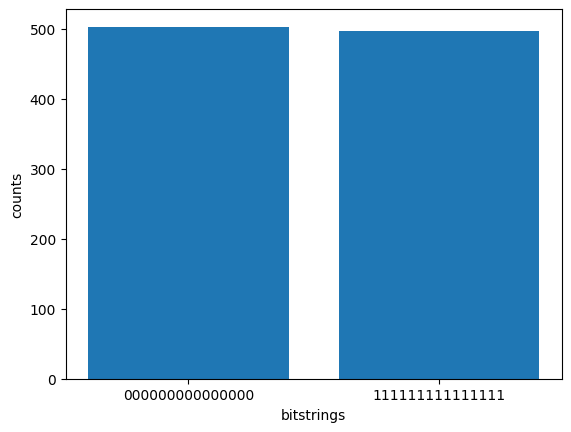

In [13]:
# define a 15-qubit GHZ circuit
n_qubits = 15
ghz = ghz_circuit(n_qubits)

# run GHZ circuit on SV1
result = device.run(ghz, shots=1000).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

The following example demonstrates that TN1 can easily simulate GHZ circuits with up to 50 qubits due to the sparse, nearest neighbor gate structure.

In [14]:
# set up the on-demand simulator TN1
# device = AwsDevice(Devices.Amazon.TN1)

In [15]:
# define a larger GHZ circuit
n_qubits = 50
ghz = ghz_circuit(n_qubits)

# run the same circuit on TN1
result = device.run(ghz, shots=1000, isStabilizerHybrid=True, isSchmidtDecompose=False, isTensorNetwork=False).result()
counts = result.measurement_counts
print(counts)

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

Counter({'00000000000000000000000000000000000000000000000000': 503, '11111111111111111111111111111111111111111111111111': 497})
Counts for all-zero bitstring: 503
Counts for all-one bitstring: 497


__NOTE__: Use unique quantum task ID to look up quantum task details in AWS console.

In [16]:
# print unique TASK ID (task = execution of individual circuit)
# task_id = result.task_metadata.id
# recover other metadata information such as number of qubits
# n = result.task_metadata.deviceParameters.paradigmParameters.qubitCount
# print('Task ID:', task_id)
# print('Number of qubits:', n)

In [17]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.00 USD
